In [1]:
import os
import random
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
### READ DATA ###

df = pd.read_csv('hour.csv')
df['dteday'] = pd.to_datetime(df.dteday)

print(df.shape)
df.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
### CASUAL COUNT STATISTICS ###

df.groupby('yr')['casual'].agg(['min','max','mean'])

,min,max,mean
yr,,,
0,0,272,28.600578
1,0,367,42.679757


In [4]:
### DEFINE CRPS METRIC ###

def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    return ((y_true-y_pred)**2).sum(axis=1).sum(axis=0) / (y_true.shape[1]*y_true.shape[0])

In [5]:
### DEFINE REGRESSOR COLUMNS ###

columns = [c for c in df.columns if c not in ['instant','dteday','casual','registered','cnt']]
print(columns)

['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


In [6]:
### TRAIN, VALIDATION, TEST SPLIT AND SCALING ###

scaler = StandardScaler()

y_train = df[df.dteday < datetime(2012, 1, 1)].casual.copy().values
train_date = df[df.dteday < datetime(2012, 1, 1)].dteday.copy()
train_h = df[df.dteday < datetime(2012, 1, 1)].hr.copy()
X_train = df[df.dteday < datetime(2012, 1, 1)][columns].copy()
X_train = scaler.fit_transform(X_train)

y_val = df[(df.dteday >= datetime(2012, 1, 1))&(df.dteday < datetime(2012, 5, 1))].casual.copy().values
val_date = df[(df.dteday >= datetime(2012, 1, 1))&(df.dteday < datetime(2012, 5, 1))].dteday.copy()
val_H = df[(df.dteday >= datetime(2012, 1, 1))&(df.dteday < datetime(2012, 5, 1))].hr.copy()
X_val = df[(df.dteday >= datetime(2012, 1, 1))&(df.dteday < datetime(2012, 5, 1))][columns].copy()
X_val = scaler.transform(X_val)

y_test = df[df.dteday >= datetime(2012, 5, 1)].casual.copy().values
test_date = df[df.dteday >= datetime(2012, 5, 1)].dteday.copy()
test_H = df[df.dteday >= datetime(2012, 5, 1)].hr.copy()
X_test = df[df.dteday >= datetime(2012, 5, 1)][columns].copy()
X_test = scaler.transform(X_test)

print(X_train.shape, X_val.shape, X_test.shape)

(8645, 12) (2894, 12) (5840, 12)


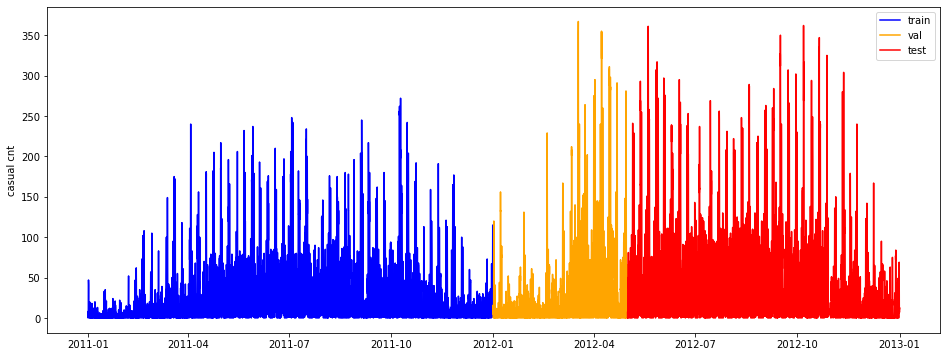

In [7]:
### CASUAL COUNT PLOT ###

plt.figure(figsize=(16,6))

plt.plot([d + np.timedelta64(h, 'h') for d,h in zip(train_date, train_h)], y_train, label='train', color='blue')
plt.plot([d + np.timedelta64(h, 'h') for d,h in zip(val_date, val_H)], y_val, label='val', color='orange')
plt.plot([d + np.timedelta64(h, 'h') for d,h in zip(test_date, test_H)], y_test, label='test', color='red')
plt.ylabel('casual cnt')
plt.legend()

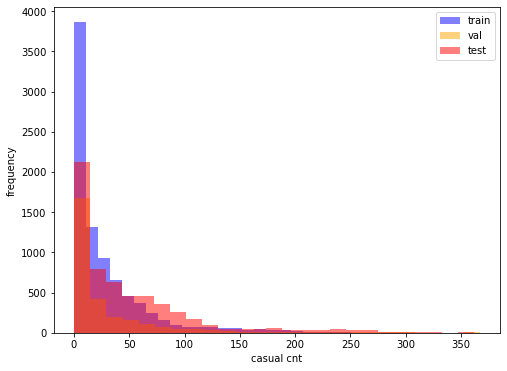

In [8]:
### CASUAL COUNT DISTRIBUTION ###

plt.figure(figsize=(8,6))

plt.hist(y_train, label='train', bins=25, alpha=0.5, color='blue')
plt.hist(y_val, label='val', bins=25, alpha=0.5, color='orange')
plt.hist(y_test, label='test', bins=25, alpha=0.5, color='red')
plt.ylabel('frequency'); plt.xlabel('casual cnt')
plt.legend()

In [9]:
### DEFINE MAX PLAUSIBLE CASUAL COUNT ###

max_count = 400

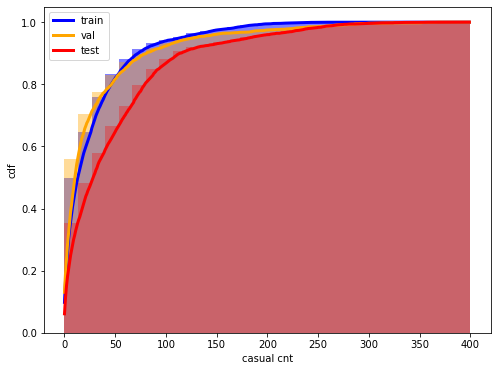

In [10]:
### CDF CASUAL COUNT PLOT ###

plt.figure(figsize=(8,6))

plt.hist(y_train, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.5, color='blue')
cdf_train = np.histogram(y_train, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf_train, c='blue', linewidth=3, label='train')

plt.hist(y_val, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.4, color='orange')
cdf_val = np.histogram(y_val, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf_val, c='orange', linewidth=3, label='val')

plt.hist(y_test, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.3, color='red')
cdf_test = np.histogram(y_test, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf_test, c='red', linewidth=3, label='test')

plt.ylabel('cdf'); plt.xlabel('casual cnt')
plt.legend()

In [11]:
### CREATE TARGETS FOR REGRESSION AND CLASSIFICATION ###

y_train_reg = np.zeros((len(y_train), max_count))
y_val_reg = np.zeros((len(y_val), max_count))
y_test_reg = np.zeros((len(y_test), max_count))

y_train_clas = np.zeros((len(y_train), max_count))
y_val_clas = np.zeros((len(y_val), max_count))
y_test_clas = np.zeros((len(y_test), max_count))


for i,cnt in enumerate(y_train):
    y_train_reg[i, cnt:] = 1
    y_train_clas[i, cnt] = 1
    
for i,cnt in enumerate(y_val):
    y_val_reg[i, cnt:] = 1
    y_val_clas[i, cnt] = 1
    
for i,cnt in enumerate(y_test):
    y_test_reg[i, cnt:] = 1
    y_test_clas[i, cnt] = 1

In [12]:
### DEFINE MODEL STRUCTURES FOR REGRESSION AND CLASSIFICATION ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model_reg():
    
    set_seed(33)
    
    opt = Adam(lr=0.01)
    
    inp = Input(shape=(len(columns)))
    x = Dense(512, activation='relu')(inp)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    out = Dense(max_count, activation='sigmoid')(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model
    
    
def get_model_clas():
    
    set_seed(33)
    
    opt = Adam(lr=0.0001)
    
    inp = Input(shape=(len(columns)))
    x = Dense(512, activation='relu')(inp)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    out = Dense(max_count, activation='softmax')(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='categorical_crossentropy')
    
    return model

# NEURAL NETWORK WITH REGRESSION

In [13]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=10)

model_reg = get_model_reg()
model_reg.fit(X_train, y_train_reg, epochs=100, batch_size=128, 
              validation_data=[X_val, y_val_reg], callbacks=[es], verbose=2)

Train on 8645 samples, validate on 2894 samples
Epoch 1/100
8645/8645 - 2s - loss: 0.0589 - val_loss: 0.0593
Epoch 2/100
8645/8645 - 1s - loss: 0.0339 - val_loss: 0.0425
Epoch 3/100
8645/8645 - 1s - loss: 0.0230 - val_loss: 0.0326
Epoch 4/100
8645/8645 - 1s - loss: 0.0199 - val_loss: 0.0333
Epoch 5/100
8645/8645 - 1s - loss: 0.0193 - val_loss: 0.0308
Epoch 6/100
8645/8645 - 1s - loss: 0.0184 - val_loss: 0.0321
Epoch 7/100
8645/8645 - 1s - loss: 0.0178 - val_loss: 0.0350
Epoch 8/100
8645/8645 - 1s - loss: 0.0176 - val_loss: 0.0297
Epoch 9/100
8645/8645 - 1s - loss: 0.0169 - val_loss: 0.0295
Epoch 10/100
8645/8645 - 1s - loss: 0.0158 - val_loss: 0.0282
Epoch 11/100
8645/8645 - 1s - loss: 0.0153 - val_loss: 0.0310
Epoch 12/100
8645/8645 - 1s - loss: 0.0152 - val_loss: 0.0278
Epoch 13/100
8645/8645 - 1s - loss: 0.0153 - val_loss: 0.0305
Epoch 14/100
8645/8645 - 1s - loss: 0.0149 - val_loss: 0.0285
Epoch 15/100
8645/8645 - 1s - loss: 0.0148 - val_loss: 0.0277
Epoch 16/100
8645/8645 - 1s - l

In [14]:
### CRPS ON VALIDATION ###

crps(y_val_reg, model_reg.predict(X_val))

0.048634997103914

In [15]:
### CRPS ON TEST ###

crps(y_test_reg, model_reg.predict(X_test))

0.07446661456669396

In [16]:
### CRPS ON TEST DATA WITH BASELINE MODEL ###

crps(y_test_reg, np.repeat(cdf_train, len(X_test)).reshape(-1,max_count))

0.12166914866721108

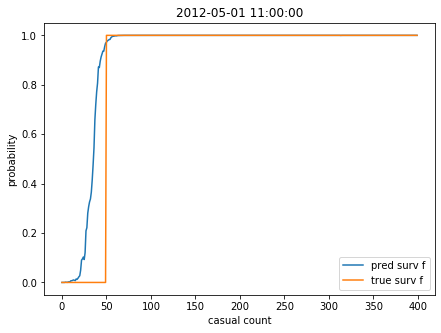

In [17]:
### PLOT PREDICTIONS ###

_id = 11

plt.figure(figsize=(7,5))
plt.plot(model_reg.predict(X_test)[_id], label='pred surv f')
plt.plot(y_test_reg[_id], label='true surv f')
plt.ylabel('probability'); plt.xlabel('casual count')
plt.title(pd.to_datetime(test_date.values[_id] + np.timedelta64(test_H.values[_id], 'h')))
plt.legend()

# NEURAL NETWORK WITH CLASSIFICATION

In [18]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=10)

model_clas = get_model_clas()
model_clas.fit(X_train, y_train_clas, epochs=100, batch_size=32, 
               validation_data=[X_val, y_val_clas], callbacks=[es], verbose=2)

Train on 8645 samples, validate on 2894 samples
Epoch 1/100
8645/8645 - 2s - loss: 4.8290 - val_loss: 3.9456
Epoch 2/100
8645/8645 - 1s - loss: 3.8963 - val_loss: 3.8685
Epoch 3/100
8645/8645 - 1s - loss: 3.7841 - val_loss: 3.8376
Epoch 4/100
8645/8645 - 2s - loss: 3.7257 - val_loss: 3.8360
Epoch 5/100
8645/8645 - 1s - loss: 3.6778 - val_loss: 3.8262
Epoch 6/100
8645/8645 - 1s - loss: 3.6483 - val_loss: 3.8123
Epoch 7/100
8645/8645 - 1s - loss: 3.6212 - val_loss: 3.7978
Epoch 8/100
8645/8645 - 1s - loss: 3.6002 - val_loss: 3.8181
Epoch 9/100
8645/8645 - 1s - loss: 3.5797 - val_loss: 3.7996
Epoch 10/100
8645/8645 - 1s - loss: 3.5551 - val_loss: 3.7941
Epoch 11/100
8645/8645 - 1s - loss: 3.5419 - val_loss: 3.7876
Epoch 12/100
8645/8645 - 1s - loss: 3.5241 - val_loss: 3.7749
Epoch 13/100
8645/8645 - 1s - loss: 3.5089 - val_loss: 3.7878
Epoch 14/100
8645/8645 - 1s - loss: 3.4992 - val_loss: 3.8041
Epoch 15/100
8645/8645 - 1s - loss: 3.4805 - val_loss: 3.7746
Epoch 16/100
8645/8645 - 1s - l

In [19]:
### CRPS ON VALIDATION ###

crps(np.cumsum(y_val_clas, axis=1), 
     np.clip(np.cumsum(model_clas.predict(X_val), axis=1), 0, 1))

0.05922218327148239

In [20]:
### CRPS ON TEST ###

crps(np.cumsum(y_test_clas, axis=1), 
     np.clip(np.cumsum(model_clas.predict(X_test), axis=1), 0, 1))

0.09114237247959403

In [21]:
### CRPS ON TEST DATA WITH BASELINE MODEL ###

crps(np.cumsum(y_test_clas, axis=1), np.repeat(cdf_train, len(X_test)).reshape(-1,max_count))

0.12166914866721108

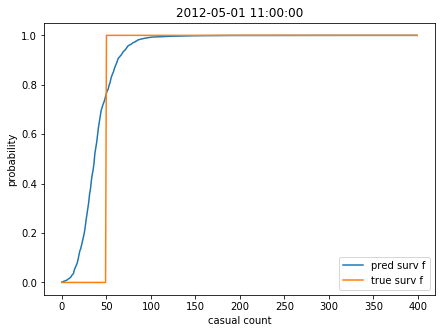

In [22]:
### PLOT PREDICTIONS ###

_id = 11

plt.figure(figsize=(7,5))
plt.plot(np.clip(np.cumsum(model_clas.predict(X_test)[_id]), 0, 1), label='pred surv f')
plt.plot(np.cumsum(y_test_clas[_id]), label='true surv f')
plt.ylabel('probability'); plt.xlabel('casual count')
plt.title(pd.to_datetime(test_date.values[_id] + np.timedelta64(test_H.values[_id], 'h')))
plt.legend()